# GFG Data Scientist Task - exploratory ML models

This Jupyter Notebook explores different Machine Learning models

In [1]:
# Import libraries

import pandas as pd
import numpy as np
from scipy import stats
pd.set_option('display.max_columns', None)

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV

In [2]:
# Read the json file provided on the github page

df_json = pd.read_json('data.json', orient='record')

In [3]:
# Create the dataframe

df_raw = pd.read_json(df_json.iloc[0,0], orient='record')

## Creating the pipeline

In [4]:
def Clean_data(df_raw=df_raw):
    
    '''Transform df_raw into df_cleaned'''
    
    global df_cleaned
    
    df_cleaned = df_raw.copy()
    
    # Replace the negative 'revenue' value by 0
    df_cleaned.loc[df_cleaned['revenue']<0,'revenue'] = 0

    # Replace each 'revenue' having 0 by the median of revenue for its specific number of items (1 to 13)
    for i in df_cleaned.loc[df_cleaned['revenue']==0,'items'].value_counts().index:  
        replace = df_cleaned.loc[df_cleaned['revenue'] != 0].groupby('items')['revenue'].median()[i]
        df_cleaned.loc[(df_cleaned['revenue']==0) & (df_cleaned['items']==i),'revenue'] = replace

    # Convert 'is_newsletter_subscriber' into 1 or 0 (1='Yes', 0 ='No').
    df_cleaned['is_newsletter_subscriber'] = np.where(df_cleaned['is_newsletter_subscriber']=='Y',1,0)

    # Create another feature for the average of revenue spend per item
    df_cleaned['avg_revenue_per_item'] = df_cleaned['revenue']/df_cleaned['items']
    
    # Create another feature for the number of returns
    df_cleaned['returns_per_item'] = df_cleaned['returns']*100/df_cleaned['items']

    # Create another feature for the number of items per order
    df_cleaned['items_per_order'] = df_cleaned['items']/df_cleaned['orders']

    # Create another feature for the online orders
    df_cleaned['online_orders'] = (df_cleaned['msite_orders'] + df_cleaned['desktop_orders'] + df_cleaned['android_orders'] + df_cleaned['ios_orders'])/ df_cleaned['orders']

    # Create another feature for the shipped items
    df_cleaned['shipped_items'] = (df_cleaned['work_orders'] + df_cleaned['home_orders'] + df_cleaned['parcelpoint_orders'])/ df_cleaned['orders']

    # Create another feature for female items
    df_cleaned['f_items'] = df_cleaned['female_items'] + df_cleaned['wapp_items'] + df_cleaned['wacc_items'] + df_cleaned['wftw_items']

    # Create another feature for male items
    df_cleaned['m_items'] = df_cleaned['male_items'] + df_cleaned['mapp_items'] + df_cleaned['macc_items'] + df_cleaned['mftw_items']

    # Create another feature for the sum of payment method
    df_cleaned['electronic_payment'] = (df_cleaned['cc_payments'] + df_cleaned['paypal_payments'] + df_cleaned['afterpay_payments'])/ df_cleaned['orders']
        
    df_cleaned = df_cleaned[['days_since_last_order', 'orders', 'avg_revenue_per_item', 'f_items','m_items','returns_per_item']]


In [5]:
def Create_X_y(df_cleaned, m=10, r=4):    
    
    '''Create X and y to fit the machine learning model'''
    
    global X_
    
    X_ = df_cleaned.copy()
    
    # Keep only obvious records which we can guess the label
    X_ = df_cleaned.loc[(df_cleaned['m_items']+df_cleaned['f_items']>=m) & (df_cleaned[['f_items','m_items']].max(axis=1)/df_cleaned[['f_items','m_items']].min(axis=1)>=r)]

    # Remove outliers
    X_ = X_.loc[(np.abs(stats.zscore(X_))<3).all(axis=1)]
    
    # Assign labels
    X_.loc[df_cleaned['f_items']/X_['m_items']>= r,'label_created'] = 1
    X_.loc[df_cleaned['m_items']/X_['f_items']>= r,'label_created'] = 0

    # Balance male and female by removing over-represented label
    remove_sample = X_['label_created'].value_counts().max() - X_['label_created'].value_counts().min()
    drop_indices = np.random.choice(X_.loc[X_['label_created']==X_['label_created'].value_counts().index[0]].index, remove_sample, replace=False)
    X_ = X_.drop(drop_indices)         
    
    # Define y_ as the column of labels
    global y_
    y_ = X_['label_created'].values
    
    # Drop labels for X_
    X_.drop('label_created',axis=1, inplace=True)
    
    # Trying to normalize our data
    X_ = np.sqrt(X_.astype('float'))
    X_ = X_.values


In [6]:
def predict(df_cleaned):
    
    '''Predict labels'''
    
    global df_predicted

    # Define df_predicted as df_raw with the new features and the predicted labels
    
    labels = pd.Series(pipe.predict(df_cleaned), name='label')
    df_predicted = pd.concat([df_raw,labels], axis=1)
    df_predicted = pd.concat([df_cleaned[['avg_revenue_per_item','f_items','m_items','returns_per_item']],df_predicted], axis=1)
    
    # Define feature_importances to understand how our models are behaving
    
    try:
        feature_importance = pipe.named_steps[list(pipe.named_steps.keys())[-1]].coef_
    
        global df_feature

        df_feature = pd.DataFrame(feature_importance,columns=df_cleaned.columns)
        
    except Exception:
        pass
    
    try:
        feature_importance2 = pipe.named_steps[list(pipe.named_steps.keys())[-1]].feature_importances_
        
        global df_feature2
        
        df_feature2 = pd.DataFrame([feature_importance2],columns=df_cleaned.columns)
        
    except Exception:
        pass

In [7]:
def plot_gender():
    
    ''' Function to plot insights related to gender'''
    
    fig, axes = plt.subplots(3,2,figsize=(20,10))
    
    list_1 = ['female_items','wapp_items','wftw_items','wacc_items','f_items','returns_per_item']
    list_2 = ['male_items','mapp_items','mftw_items','macc_items','m_items','orders']
    
    for index,col in enumerate(zip(list_1, list_2)):
        i, k = divmod(index,2)
        sns.scatterplot(data=df_predicted, x=col[0], y=col[1], hue='label', alpha=0.2, ax=axes[i,k])
        axes[i,k].set_yscale('symlog')
        axes[i,k].set_xscale('symlog')

    plt.tight_layout()

In [8]:
def plot_others():
    
    ''' Function to plot other insights'''
    
    fig, axes = plt.subplots(1,4,figsize=(20,5))

    sns.countplot(data=df_predicted, x='label', ax=axes[0])
    axes[0].set_title('Count of males and females')
    
    sns.stripplot(data=df_predicted, x='label', y='avg_revenue_per_item', alpha=0.2, hue='label', jitter=True, ax=axes[1])
    axes[1].set_title('Predicted labels with regards to "avg_revenue_per_item"')
    axes[1].set_yscale('symlog')
    axes[1].set_ylim(0)
    
    sns.stripplot(data=df_predicted, x='label', y='items', alpha=0.2, hue='label', jitter=True, ax=axes[2])
    axes[2].set_title('Predicted labels with regards to "items"')
    axes[2].set_yscale('symlog')
    axes[2].set_ylim(0)
    
    sns.stripplot(data=df_predicted, x='label', y='returns_per_item', alpha=0.2, hue='label', jitter=True, ax=axes[3])
    axes[3].set_title('Predicted labels with regards to "returns_per_item"')
    axes[3].set_yscale('symlog')
    axes[3].set_ylim(0)
    
    plt.tight_layout()

## Exploring machine learning models

#### Logistic Regression

In [9]:
# Let's explore Logistic Regression first

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [10]:
Clean_data() # --> Transform df_raw into df_cleaned
Create_X_y(df_cleaned) # --> Create X_ and y_ 
pipe.fit(X_, y_) # --> Use X_ and y_ to fit the model
predict(df_cleaned) # --> apply to model to df_cleaned to predict labels

In [11]:
print(f"Ratio of females versus males: {df_predicted['label'].value_counts()[1]/df_predicted['label'].value_counts()[0]}")

Ratio of females versus males: 1.5432028185867182


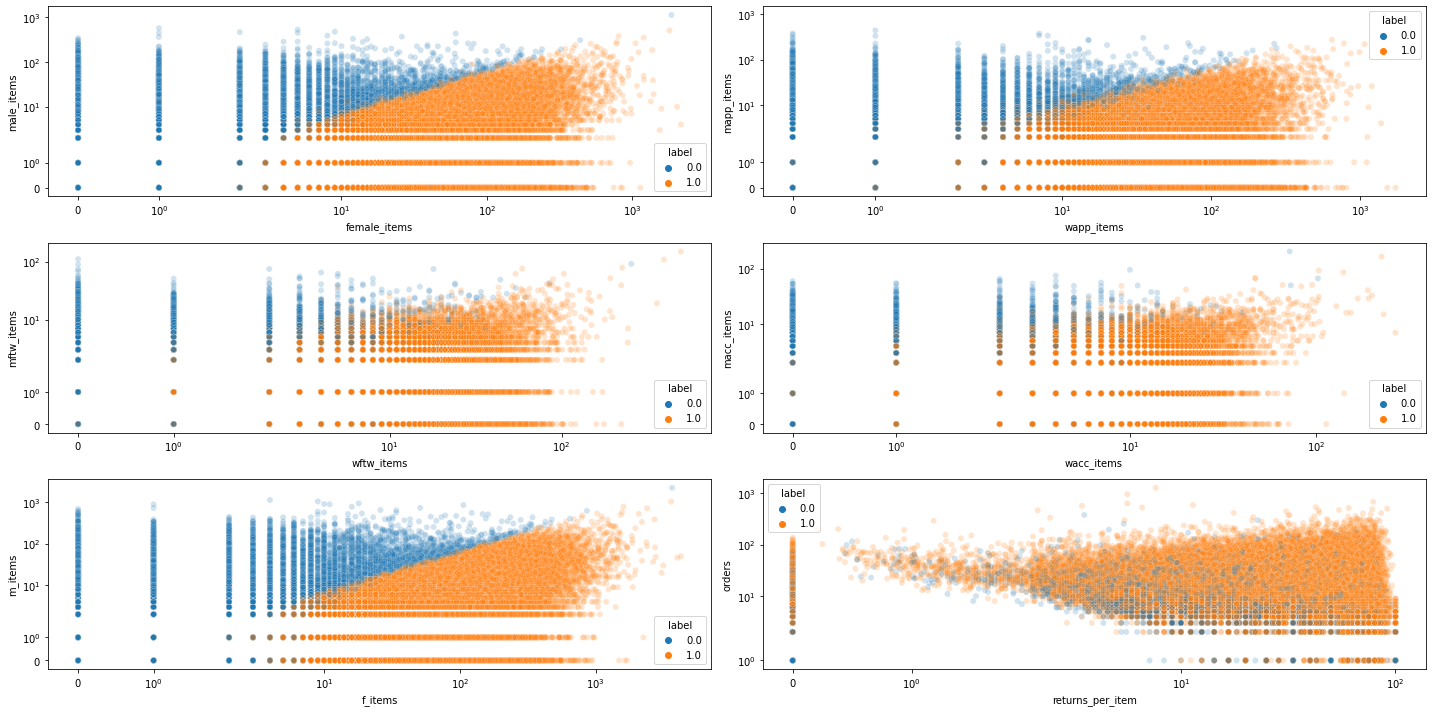

In [12]:
plot_gender()

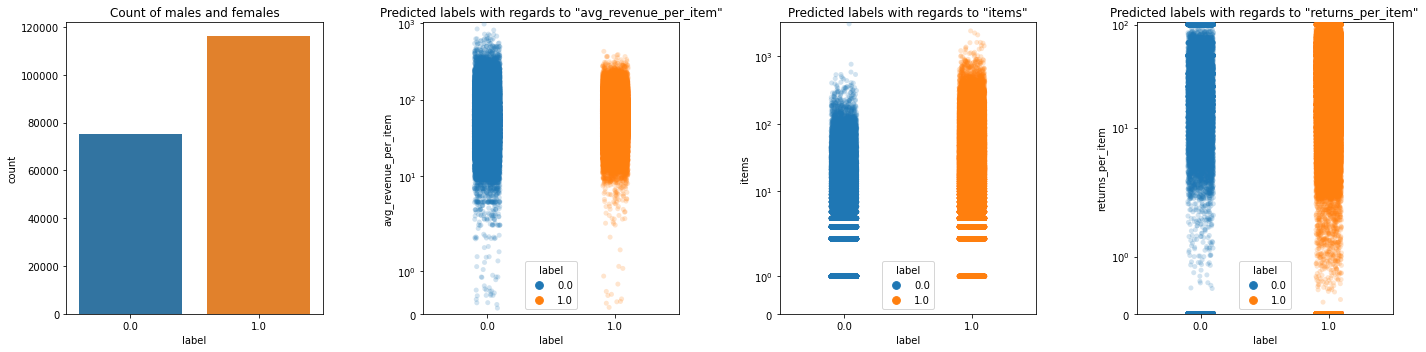

In [13]:
plot_others()

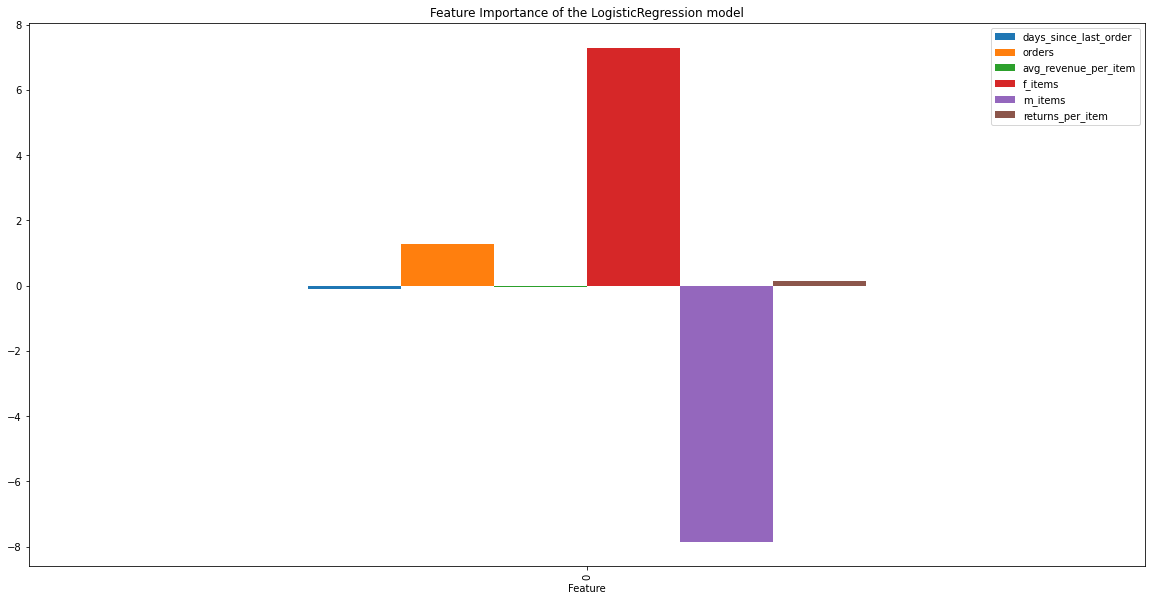

In [14]:
df_feature.plot(kind='bar', figsize=(20,10))
plt.title(f"Feature Importance of the {str(pipe.named_steps[list(pipe.named_steps.keys())[-1]]).split('(')[0]} model")
plt.xlabel('Feature');

In [15]:
# A look at the accuracy of the model with train and test samples

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.95)
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
score = accuracy_score(yhat, y_test)
print(f"With only {X_train.shape[0]} samples to train from, the accuracy score of the model is {score}.")

With only 1396 samples to train from, the accuracy score of the model is 1.0.


Even with only 1396 samples, the LogisticRegression model understands easily that I based my labels creation on f_items and m_items.


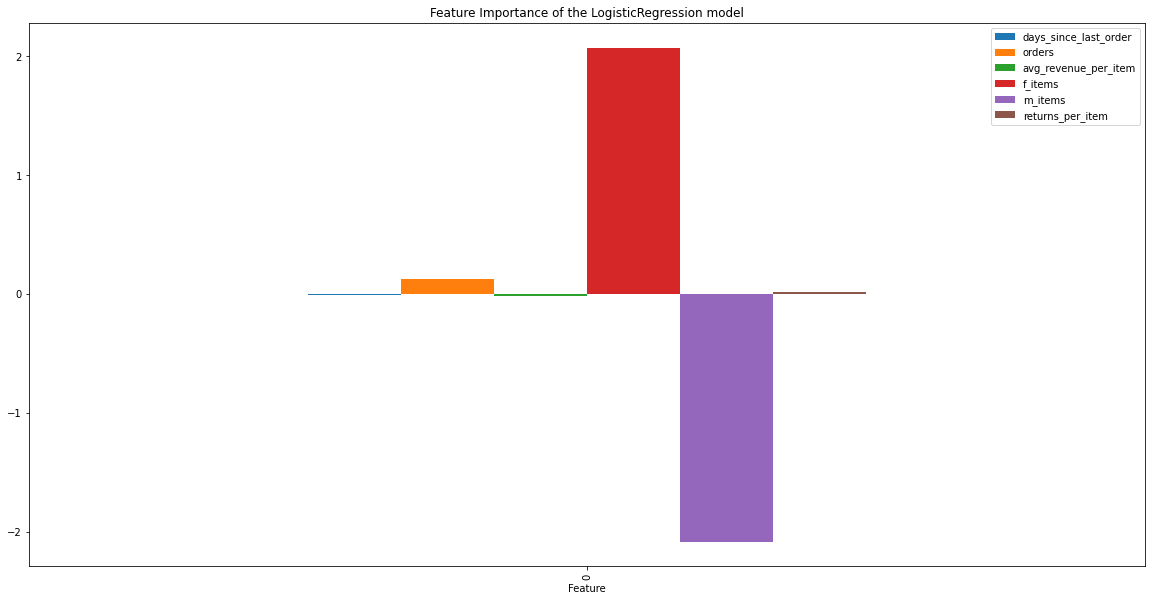

In [16]:
# Plot feature_importances of the model

pd.DataFrame(model.coef_,columns=df_cleaned.columns).plot(kind='bar', figsize=(20,10))
plt.title(f"Feature Importance of the {str(model).split('(')[0]} model")
plt.xlabel('Feature')
print(f"Even with only {X_train.shape[0]} samples, the {str(model).split('(')[0]} model understands easily that I based my labels creation on f_items and m_items.");

#### K-means 

Note: K-means(n_clusters=2) is clustering the data into 2 groups, however it does not mean those 2 groups represent female and male. Therefore, label 0 and 1 should not be interpreted as 'female' or 'male'.

In [17]:
# Define the pipeline

pipe = make_pipeline(StandardScaler(), KMeans(n_clusters=2, init='k-means++', max_iter=500))

In [18]:
Clean_data() # --> Transform df_raw into df_cleaned
Create_X_y(df_cleaned) # --> Create X_ and y_ 
pipe.fit(X_, y_) # --> Use X_ and y_ to fit the model
predict(df_cleaned) # --> apply to model to df_cleaned to predict labels

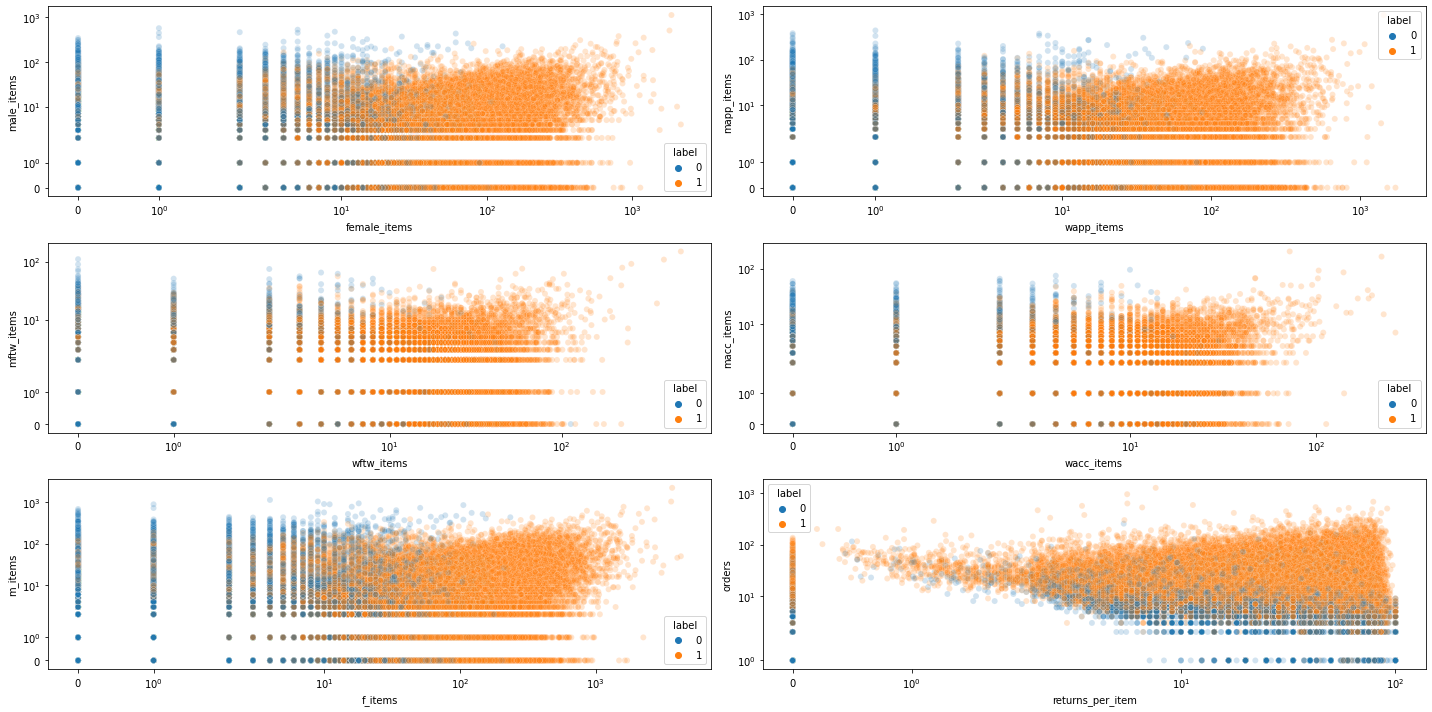

In [19]:
plot_gender()

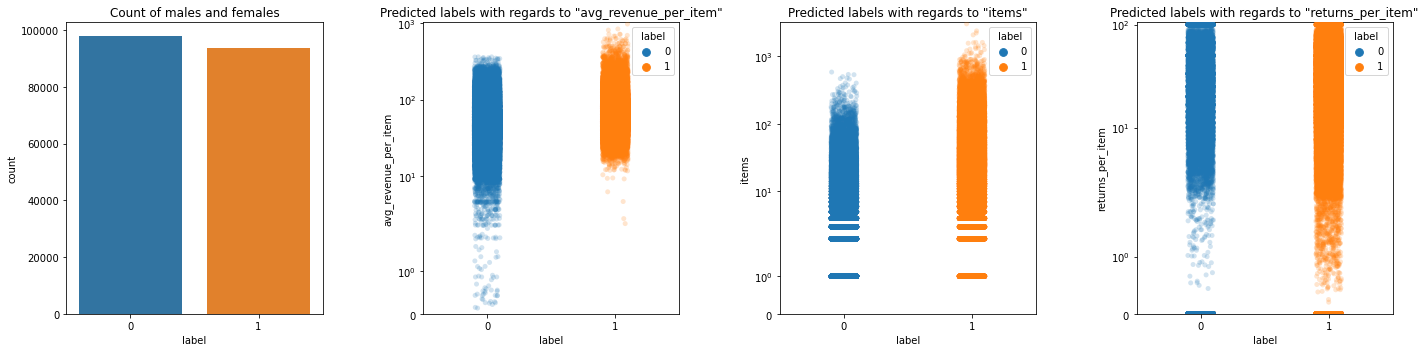

In [20]:
plot_others()

In [21]:
print(f"Ratio of females versus males: {df_predicted['label'].value_counts()[1]/df_predicted['label'].value_counts()[0]}")

Ratio of females versus males: 0.955999795490567


In [22]:
# Count of each label

df_predicted['label'].value_counts()

0    97795
1    93492
Name: label, dtype: int64

In [23]:
# Mean of the 'item' column for label 0

df_predicted.loc[df_predicted['label']==0, 'items'].mean()

7.440595122450023

In [24]:
# Mean of the 'item' column for alebl 1

df_predicted.loc[df_predicted['label']==1,'items'].mean()

42.43596243528858

I was hoping to see K-means clustering the data into 2 distinct groups based more or less on gender 'distance'. We have to be aware that there is no guarantee that the clusters we get will correspond to the categories we want.

#### KNN (K-nearest Neighbors)

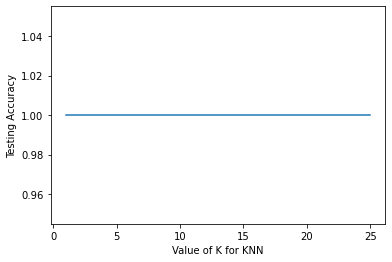

In [25]:
# What is the best n_neighbors value?
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.7)

# Try K=1 through K=25 and record testing accuracy
k_range = range(1, 26)

scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy');

# We will take n_neighbors equal to 5.

In [26]:
# Define the pipeline

pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, weights='uniform'))

In [27]:
Clean_data() # --> Transform df_raw into df_cleaned
Create_X_y(df_cleaned) # --> Create X_ and y_ 
pipe.fit(X_, y_) # --> Use X_ and y_ to fit the model
predict(df_cleaned) # --> apply to model to df_cleaned to predict labels

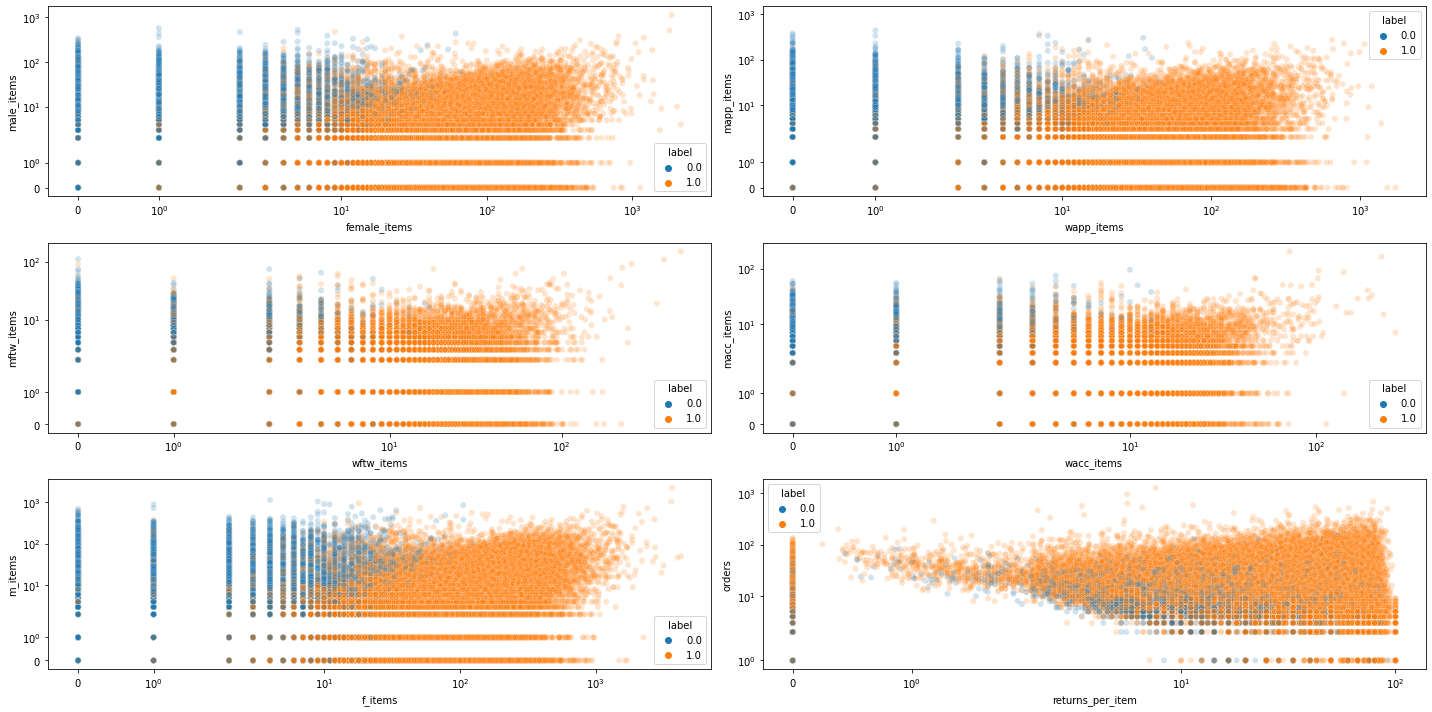

In [28]:
plot_gender()

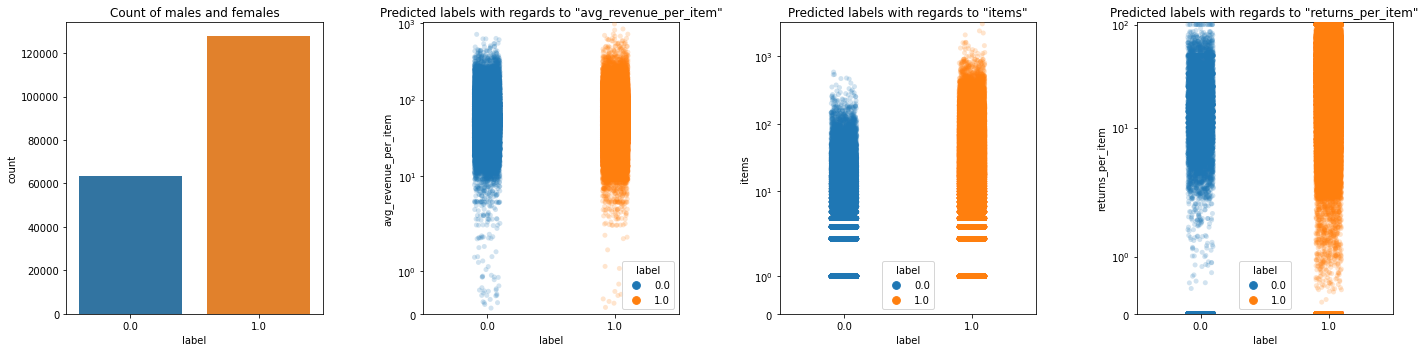

In [29]:
plot_others()

In [30]:
print(f"Ratio of females versus males: {df_predicted['label'].value_counts()[1]/df_predicted['label'].value_counts()[0]}")

Ratio of females versus males: 2.0090766084631113


#### RandomForestClassifier

In [31]:
# Define the pipeline

pipe = make_pipeline(StandardScaler(), RandomForestClassifier())

In [32]:
Clean_data() # --> Transform df_raw into df_cleaned
Create_X_y(df_cleaned) # --> Create X_ and y_ 
pipe.fit(X_, y_) # --> Use X_ and y_ to fit the model
predict(df_cleaned) # --> apply to model to df_cleaned to predict labels

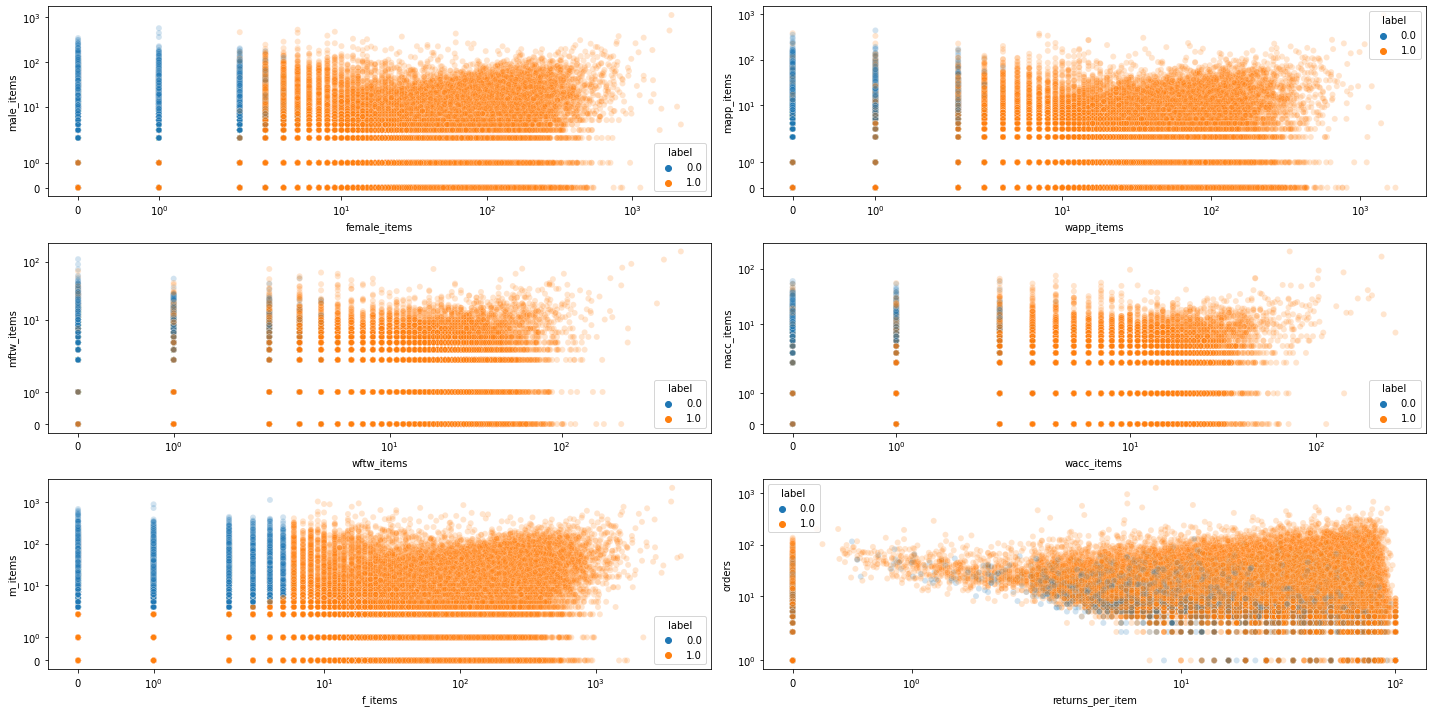

In [33]:
plot_gender()

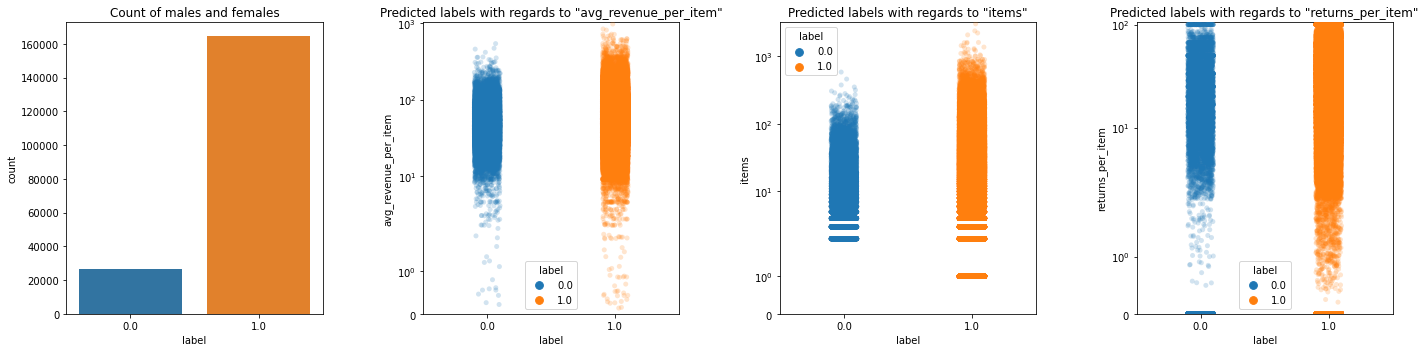

In [34]:
plot_others()

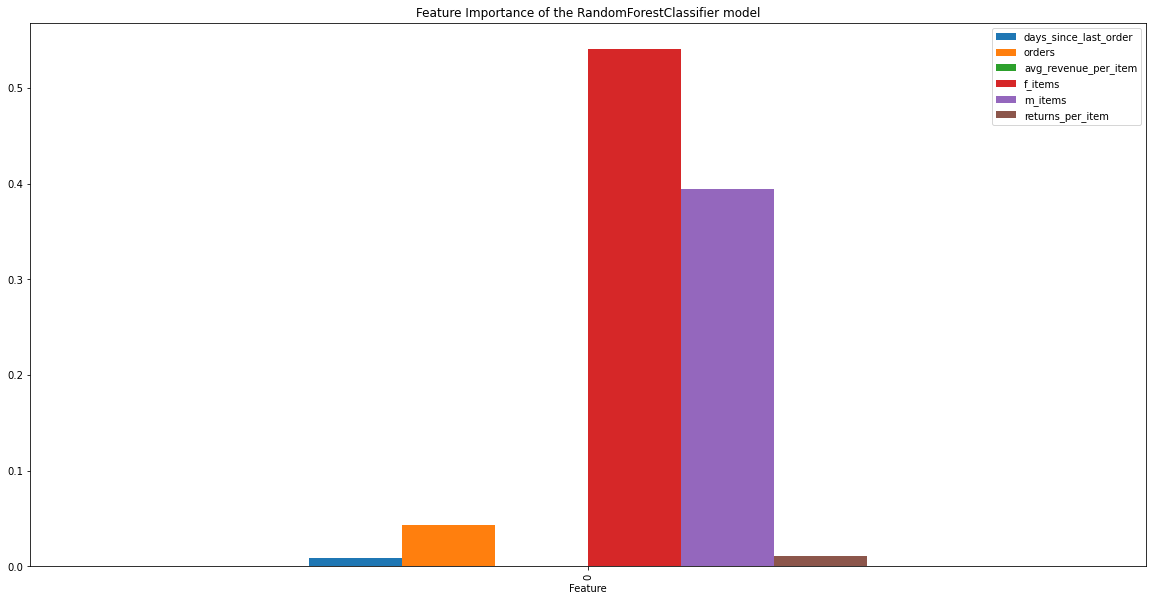

In [35]:
df_feature2.plot(kind='bar', figsize=(20,10))
plt.title(f"Feature Importance of the {str(pipe.named_steps[list(pipe.named_steps.keys())[-1]]).split('(')[0]} model")
plt.xlabel('Feature');

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.995)
model = RandomForestClassifier()
model.fit(X_train, y_train)
yhat = model.predict(X_test)
score = accuracy_score(yhat, y_test)
print(f"With only {X_train.shape[0]} samples to train from, the accuracy score of the model is {score}.")

With only 139 samples to train from, the accuracy score of the model is 0.98999964027483.


Even with only 139 samples, the RandomForestClassifier model figures out that I based my labels creation on female_items and male_items.


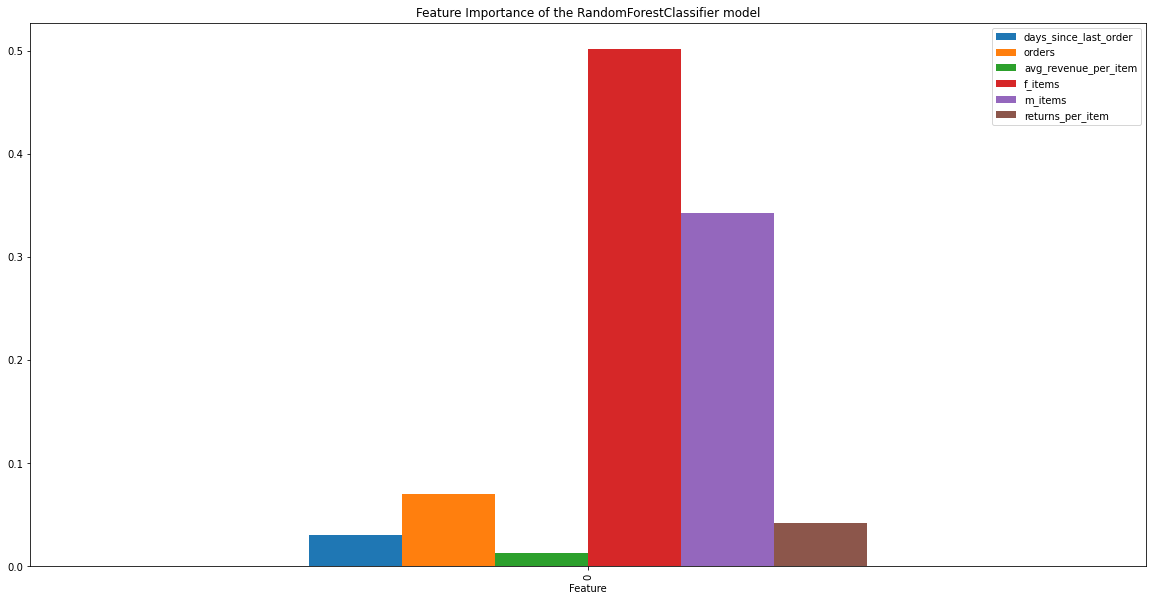

In [37]:
pd.DataFrame([model.feature_importances_],columns=df_cleaned.columns).plot(kind='bar', figsize=(20,10))
plt.title(f"Feature Importance of the {str(model).split('(')[0]} model")
plt.xlabel('Feature')
print(f"Even with only {X_train.shape[0]} samples, the {str(model).split('(')[0]} model figures out that I based my labels creation on female_items and male_items.");

In [38]:
print(f"Ratio of females versus males: {df_predicted['label'].value_counts()[1]/df_predicted['label'].value_counts()[0]}")

Ratio of females versus males: 6.14237174221492


#### Support Vector Classification (SVC)

In [39]:
pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))

In [40]:
Clean_data() # --> Transform df_raw into df_cleaned
Create_X_y(df_cleaned) # --> Create X_ and y_ 
pipe.fit(X_, y_) # --> Use X_ and y_ to fit the model
predict(df_cleaned) # --> apply to model to df_cleaned to predict labels

In [41]:
print(f"Ratio of females versus males: {df_predicted['label'].value_counts()[1]/df_predicted['label'].value_counts()[0]}")

Ratio of females versus males: 3.7103422802265453


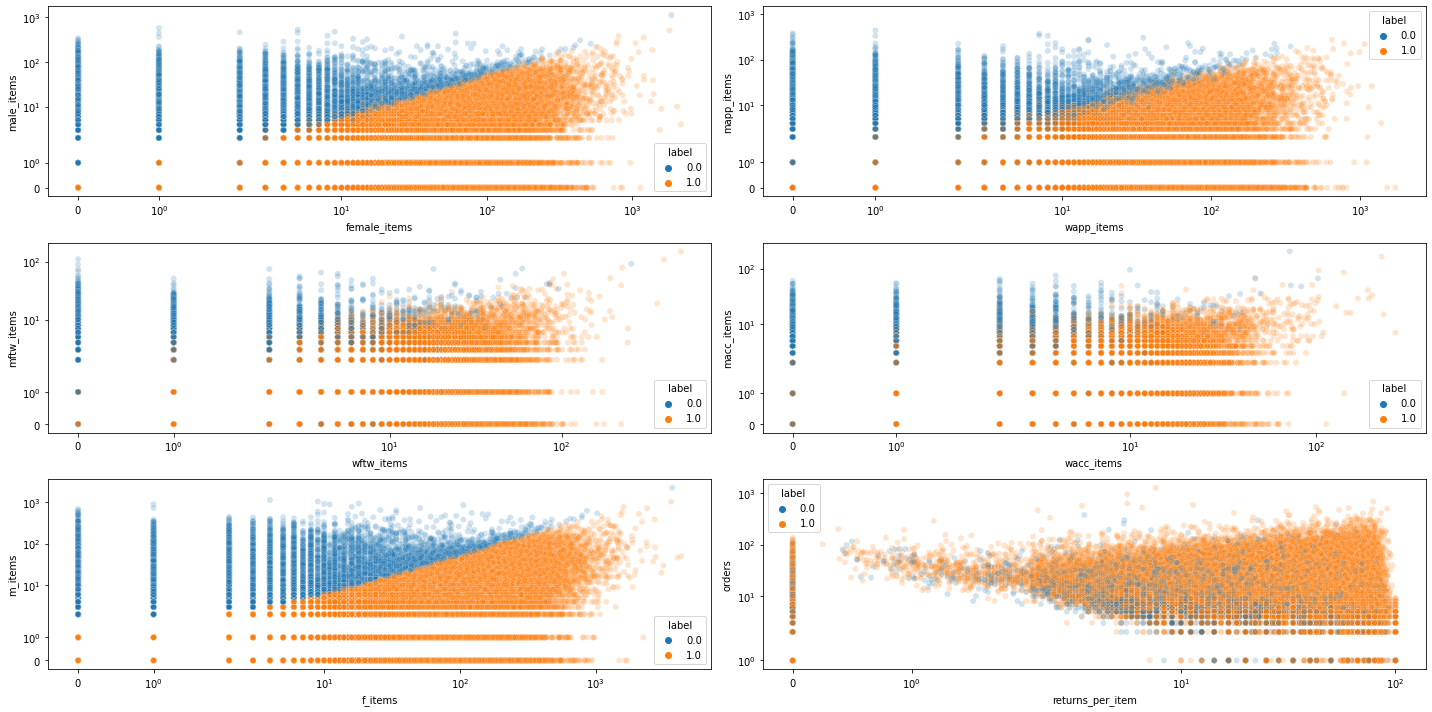

In [42]:
plot_gender()

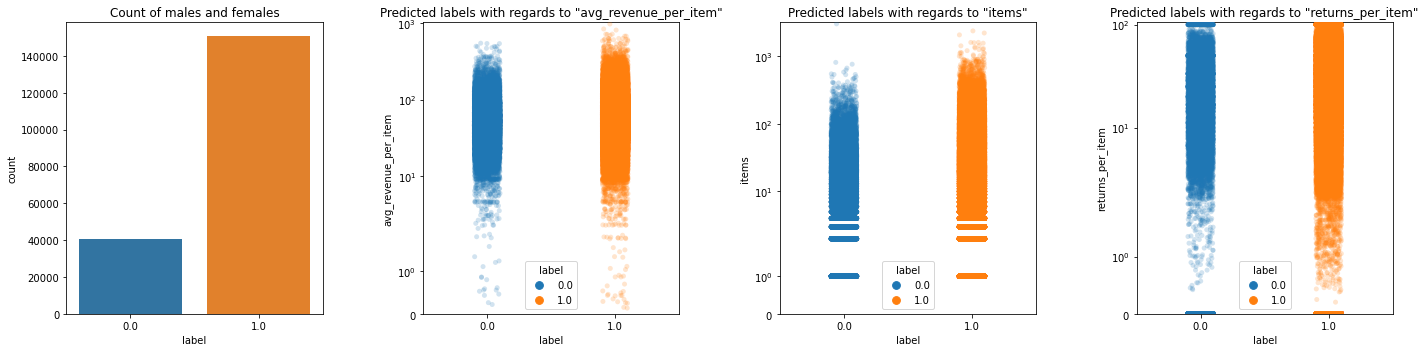

In [43]:
plot_others()

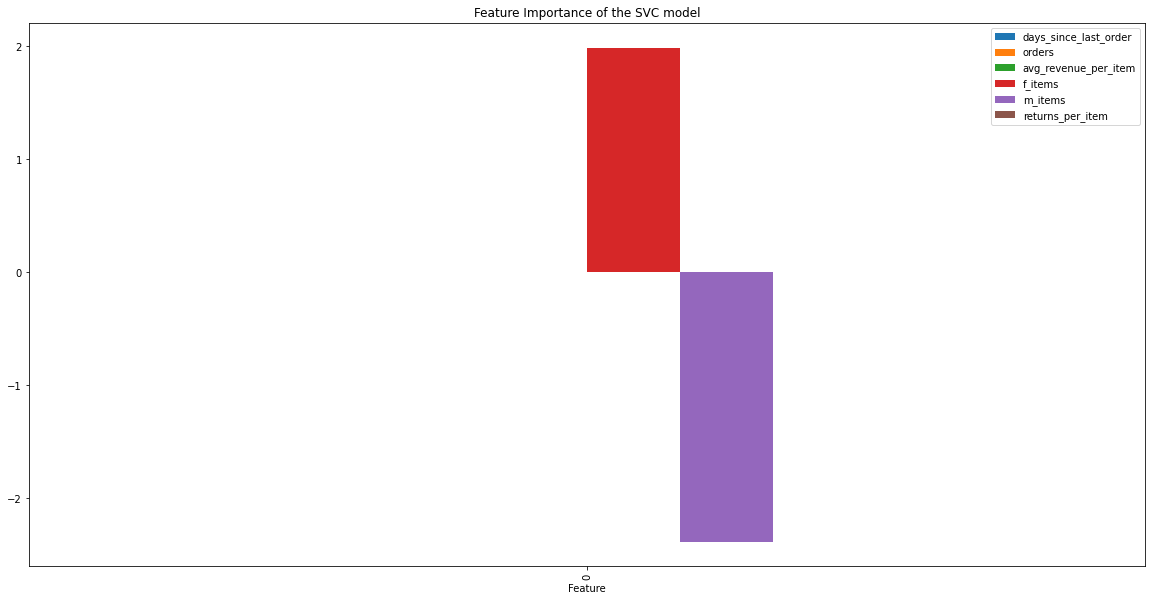

In [44]:
df_feature.plot(kind='bar', figsize=(20,10))
plt.title(f"Feature Importance of the {str(pipe.named_steps[list(pipe.named_steps.keys())[-1]]).split('(')[0]} model")
plt.xlabel('Feature');

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.97)
model = SVC(kernel='linear')
model.fit(X_train, y_train)
yhat = model.predict(X_test)
score = accuracy_score(yhat, y_test)
print(f"With only {X_train.shape[0]} samples to train from, the accuracy score of the model is {score}.")

With only 838 samples to train from, the accuracy score of the model is 1.0.


Even with only 838 samples, the SVC model figures out that I based my labels creation on female_items and male_items.


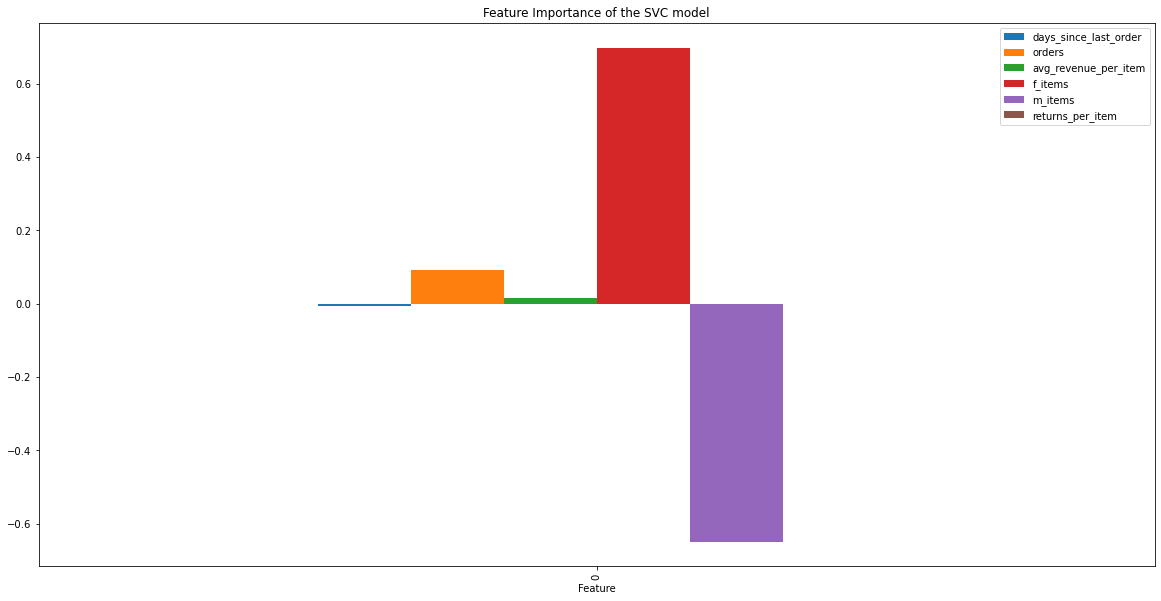

In [46]:
pd.DataFrame(model.coef_,columns=df_cleaned.columns).plot(kind='bar', figsize=(20,10))
plt.title(f"Feature Importance of the {str(model).split('(')[0]} model")
plt.xlabel('Feature')
print(f"Even with only {X_train.shape[0]} samples, the {str(model).split('(')[0]} model figures out that I based my labels creation on female_items and male_items.");